In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [3]:
# 导入之前已经清洗过的数据
base_path = './lianjia_data/'
data = pd.read_csv(base_path+'reorganized_data/reorganized.csv')

In [4]:
data.head()

,district,town_name,description,listed_price,layout,total_area,direction,decoration_rate,stairs,built_year,building_type
0,xuhui,kangjian,中间楼层，欧式装修，全明边套净收眼底必看好房,375.0,2室0厅,53.92,南,精装,中楼层(共4层),1992,板楼
1,xuhui,kangjian,花苑村紫竹园 2室1厅 468万必看好房,468.0,2室1厅,67.11,南,简装,6层,1990,板楼
2,xuhui,kangjian,南北两房全明户型采光充足 近上海南站地铁站 诚售。必看好房,468.0,2室1厅,68.03,南,精装,低楼层(共6层),1991,板楼
3,xuhui,kangjian,桂莘小区 双南双天井 精装三房 近地铁十二号线必看好房,520.0,3室1厅,78.38,南,精装,低楼层(共6层),1997,板楼
4,xuhui,kangjian,精装电梯三房，近地铁，双阳台，闹中取静，值得拥有。必看好房,499.0,3室1厅,110.66,东南,精装,28层,1996,塔楼


In [5]:
# 将数据打乱
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,district,town_name,description,listed_price,layout,total_area,direction,decoration_rate,stairs,built_year,building_type
0,baoshan,zhangmiao,泗塘四村 1室1厅 175万,175.0,1室1厅,41.15,南,简装,中楼层(共6层),1987,板楼
1,pudong,zhoupu,精致小两房，没有个税，南北通户型 看房方便房主自荐,350.0,2室1厅,72.80,南,精装,高楼层(共6层),2006,板楼
2,xuhui,changqiao,精装修南北两房、南北花园绿地！,680.0,2室1厅,90.59,南 北,精装,12层,2008,板楼
3,pudong,xinchang,东方冠郡 2室2厅 270万,270.0,2室2厅,90.96,南,精装,中楼层(共6层),2007,板楼
4,pudong,zhoupu,三轨交汇，中金二期精装小三房，带zhongyang空调,425.0,3室2厅,94.77,南 北,精装,低楼层(共8层),2013,板楼


In [6]:
# 把之前用0替代的建成年改为nan
data['built_year'][data['built_year']==0] = np.nan

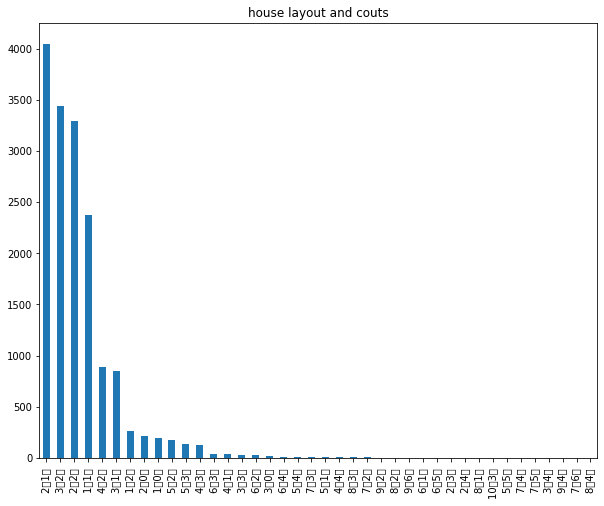

In [7]:
# 接下来先造几个简单的特征
# 看看layout, direction, decoration_rate, stairts, building_type
# 这几个看起来可选值比较少的分布
data['layout'].value_counts().plot(kind='bar', title='house layout and couts',figsize=(10, 8))

In [8]:
# 可以看到大多数房子房间数在1-4之间，而客厅数在1-2之间
# 现在分别为房间数和客厅数造特征
tmpdf = data['layout'].str.extract(r'([0-9]+室)([0-9]+厅)')

In [9]:
tmpdf.head(3)

,0,1
0,1室,1厅
1,2室,1厅
2,2室,1厅


In [10]:
data['rooms'] = tmpdf.loc[:, 0].str.extract(r'([0-9]+)').astype('int64')

In [11]:
data['living_rooms'] = tmpdf.loc[:, 1].str.extract(r'([0-9]+)').astype('int64')

In [12]:
# 看看房子朝向
data['direction'].value_counts()

 南               12046
 南 北              3077
 东南                213
 西南                180
 东                 113
 北                  98
 西                  79
 暂无数据               50
 北 南                45
 西北                 34
 南 西                28
 东 西                28
 东南 南               26
 东北                 21
 南 西南               20
 东 南                18
 东 南 北              17
 南 西 北              15
 南 东                10
 东 东南                8
 东 北                 5
 东南 西北               4
 西南 西                4
 东南 北                4
 西 南                 4
 西 北                 3
 西南 南                3
 南 北 西               3
 西南 东北               3
 南 东南                2
 东南 西南               2
 东南 南 北              2
 西 西南                2
 南 西北                2
 东 东南 南              2
 西 南 北               2
 南 东 西               2
 南 西南 北              2
 东 东南 东北             1
 南 西南 西 西北 北         1
 西 东                 1
 东 西南 北              1
 西南 西北               1
 东北 西      

In [13]:
(data['direction'].apply(lambda x: x.strip()) == '南').sum() / data.shape[0] 

0.7436720582787999

In [14]:
# 超过7成房子朝向显示为南
# 来看看有多少房子的朝向提到了南
data['direction'].str.contains('南', regex=False).sum() / data.shape[0]

0.9730830966786023

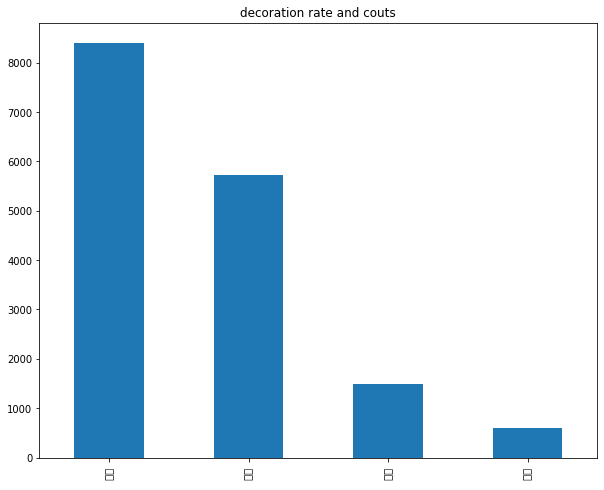

In [15]:
# 几乎全部的房子朝向都写了南，或东南， 西南之类
# 说明朝向确实不具有预测性
# 现在来看看装修等次
data['decoration_rate'].value_counts().plot(kind='bar', title='decoration rate and couts',figsize=(10, 8))

In [16]:
data['decoration_rate'].value_counts()

 精装     8390
 简装     5715
 毛坯     1499
 其他      594
Name: decoration_rate, dtype: int64

In [17]:
# 精装， 简装， 毛坯及其他数量依次减小
# 一般中介在评定房子装修等次时，对只要不是装修得特别简单都定位精装，
# 所以简装和精装之间有较大差别， 而精装之间也可以有很大差别。
# 当然，毛坯和有装修的在定价时差别较大， 所以，装修等次应是重要预测特征。我们稍后再看。


In [18]:
# 看看楼层描述
data['stairs'] = data['stairs'].apply(lambda x: x.strip())
data['stairs'].str.contains('[低中高]楼层.*共[0-9]+层').sum() / data.shape[0]

0.9599950611186566

In [19]:
# 只有少量房子没有包含楼层高低和中层数
# 他们只含有其中之一，
# 我们来为楼层高低和总层数分别造特征
data['floor_height'] = data['stairs'].str.extract(r'([低中高])')
data['total_floors'] = data['stairs'].str.extract(r'(\d+)')

In [20]:
data.head(3)

,district,town_name,description,listed_price,layout,total_area,direction,decoration_rate,stairs,built_year,building_type,rooms,living_rooms,floor_height,total_floors
0,baoshan,zhangmiao,泗塘四村 1室1厅 175万,175.0,1室1厅,41.15,南,简装,中楼层(共6层),1987.0,板楼,1,1,中,6
1,pudong,zhoupu,精致小两房，没有个税，南北通户型 看房方便房主自荐,350.0,2室1厅,72.80,南,精装,高楼层(共6层),2006.0,板楼,2,1,高,6
2,xuhui,changqiao,精装修南北两房、南北花园绿地！,680.0,2室1厅,90.59,南 北,精装,12层,2008.0,板楼,2,1,NaN,12


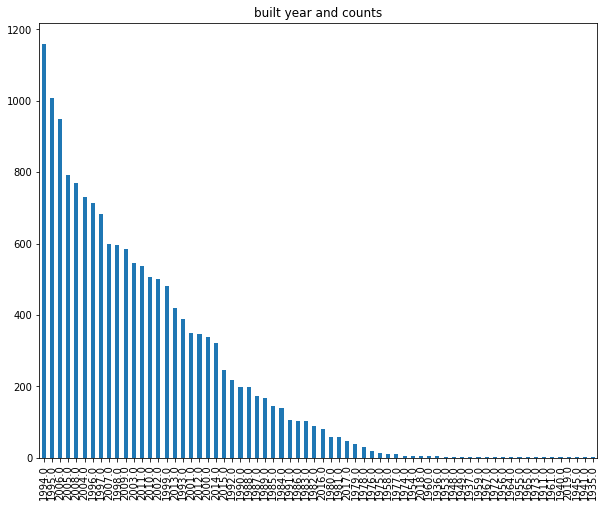

In [21]:
data['built_year'].value_counts().plot(kind='bar', title='built year and counts', figsize=(10, 8))

In [22]:
data['built_year'].describe()

count    15624.000000
mean      2000.842614
std          8.686471
min       1911.000000
25%       1995.000000
50%       2002.000000
75%       2007.000000
max       2019.000000
Name: built_year, dtype: float64

In [23]:
# 可以看到这些二手房的修建年代平均是在2000年
# 最早在1911年， 最迟在2019年


In [24]:
# 看看1911年的二手房
data.loc[data['built_year']==1911., :]

,district,town_name,description,listed_price,layout,total_area,direction,decoration_rate,stairs,built_year,building_type,rooms,living_rooms,floor_height,total_floors
2434,xuhui,hengshanlu,淮海路历史保护建筑，售后公房，看房方便！,1250.0,2室1厅,92.91,南,简装,低楼层(共7层),1911.0,板楼,2,1,低,7


In [25]:
# 可以看到这是一个历史保护建筑，虽然只有90多平米， 2室一厅， 挂牌价却超过1200万
# 再来看看2019 年修的房子， 究竟为什么要把刚修的房子按二手房卖
data.loc[data['built_year']==2019., :]

,district,town_name,description,listed_price,layout,total_area,direction,decoration_rate,stairs,built_year,building_type,rooms,living_rooms,floor_height,total_floors
226,pudong,yuqiao1,小区中间位置，少有户型4房，户型方正，60万装修,1240.0,4室2厅,140.0,南 北,精装,高楼层(共10层),2019.0,板楼,4,2,高,10


In [26]:
# 根据描述，似乎业主刚卖到房子且花了相当一笔钱装修之后就将房子做二手出售
# 因二手房通常价格低于一手，且在lianjia挂牌出售要付中介费及税，所以不是太清楚为何如此。
# 次房平均每平米挂牌价在9万， 超出lianjia上在此地区平均价格很多
# 这两个数据相当不具有代表性，应视为outliers
# 且我们可以看到一半的房子建于1995-2007年间

In [27]:
# 看看楼型
data['building_type'].value_counts()

 板楼             14753
 塔楼               916
 板楼 | 独栋别墅        208
 板楼 | 联排别墅         97
 板塔结合              89
 暂无数据              57
 板楼 | 双拼别墅         38
 板楼 | 叠拼别墅         27
 板楼 | 暂无数据别墅        9
 平房                 2
 独栋别墅               1
 塔楼 | 独栋别墅          1
Name: building_type, dtype: int64

In [28]:
# 推荐描述多是套话，千篇一律，但或许也有有价值的信息
# 会影响顾客的购买意向或价格
# 先看看前20个数据的描述
data['description'][:20]

0                       泗塘四村 1室1厅 175万
1            精致小两房，没有个税，南北通户型 看房方便房主自荐
2                      精装修南北两房、南北花园绿地！
3                       东方冠郡 2室2厅 270万
4          三轨交汇，中金二期精装小三房，带zhongyang空调
5                  乾溪二村，看房方便，毛坯房，改动空间大
6        1楼带院子，一梯两户南北通透，近地铁6号线金桥路站必看好房
7        房子满五唯一，税费少，精装修，有车位，业主诚意出售房主自荐
8     满五年唯一，看房方便，2010年小区，S3高架，11号线房主自荐
9            满五唯一  楼层适中  得房率高  近地铁房主自荐
10          中间楼层 两房朝南，厨卫都是明窗 诚心出售 看房方便
11                房子南、北两室，位置好，户型好，采光很棒
12                 潍坊八村，精装两房，满五唯一，上学方便
13                      泉东小区 1室1厅 450万
14            富力精装两房 一楼带院子 高品质小区 全人车分流
15           临港品质小区 房龄新 小区环境佳 好楼层，满五唯一
16                     满五唯一，高层复式，采光无遮挡
17            商品房满五年，原始户型，呼兰站996米，天然公园
18              近16号、交通便利、精装修 南北正通 户型正
19          顾村公园 刘行站 一手动迁 大三房飞机场户型130平
Name: description, dtype: object

In [29]:
# 在看接着的30个
data['description'][20:50]

20    万科新上南北两房 业主自住精装修 随时看房 满五唯一必看好房
21           近地铁 满5唯一 南北通透 房型正气 看房方便
22         南北两房 满五年 唯一 中间楼层 业主置换 诚意售
23         百万装修，专属定制，满屋尽显尊贵，业主入住不到一年
24          潼港八村2房 地铁6号线沿线 交通便利 价格可谈
25          此房一手动迁，满五，双南户型两房，通风好房主自荐
26              小区是11年次新房，距离地铁近，交通便利
27               花园位置，户型正气，诚意出售，价格可谈
28           杨思前滩＋8号线杨思＋简装修＋采光好＋配套齐全
29         枫桦景苑一期空中别墅 使用面积大 诚心出售看房方便
30                精装！单价低，总价低，业主诚意出售！
31          满五唯一，简装两房，临河位置，诚意出售。房主自荐
32           户型正气，采光充足，配套齐全，交通便利，近地铁
33          近16号线，电梯中层，全明户型，税费少，诚意出售
34            动迁房交易，采光充足，自己一家人住，看房方便
35          多层五楼、清水毛坯，小区景观位置，置换诚心出售、
36     不靠路，动迁满五税费少，双花园，朝南无遮挡视野开阔房主自荐
37            海尚康庭精装大三房，满五年不唯一，户型采光好
38                 双南两房，楼层好，采光好，视野开阔
39           高区南北通三房，位于小区中-心位置，闹中取静！
40          原始三房，融创门口，双阳台，三条地铁线，诚心出售
41               满二唯一，采光好，格局好，业主诚心出售
42        家的港湾 爱的始点 梦的归宿 满五唯一 示范级幼儿园
43             2房朝南，采光好+无抵押+产权清晰必看好房
44          户型通透 看楼下绿化景观 看房方便 业主诚意出售
45      9号线地铁口 客厅南北通透 视线好 业主诚意出售房主自荐
46            明天华城 三期 双南两房 中间楼层 诚意出售
4

In [30]:
# 满五唯一，满五， 不满五 是很重要的参考
# 倘若未提及，一般是不符合
# 靠近地铁或许表明位置不错，也可以参考
# 因为很多二手房的价格由学区决定，所以我们看看描述中是否会出现这类词
data['description'].str.contains('学校|学区', regex=True).any()

False

In [31]:
# 并没有
# 我们来据此构造几个特征
# 首先是满五唯一
data['m5w1'] = data['description'].str.extract('(满五唯一)')


In [32]:
data['m5w1'][:10]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7    满五唯一
8     NaN
9    满五唯一
Name: m5w1, dtype: object

In [33]:
 data['m5w1'][data['m5w1'].isnull() & data['description'].str.contains('满五', regex=False)]= '满五不唯一'

In [34]:
 data['m5w1'][:10]

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7     满五唯一
8    满五不唯一
9     满五唯一
Name: m5w1, dtype: object

In [35]:
data['description'].str.contains('地铁', regex=False).sum()

1938

In [36]:
data['description'].str.contains('公园', regex=False).sum()

241

In [37]:
data['description'].str.contains('学校', regex=False).sum()

0

In [38]:
data['description'].str.contains('超市', regex=False).sum()

9

In [39]:
data['description'].str.contains('大学', regex=False).sum()

7

In [40]:
data['description'].str.contains('公交', regex=False).sum()

28

In [41]:
# 构造特征表明房子是否靠近公共设施
data['near_facilities'] = data['description'].str.contains('地铁|公园|学校|超市|大学|公交')

In [42]:
# 检查数据
data.head()

,district,town_name,description,listed_price,layout,total_area,direction,decoration_rate,stairs,built_year,building_type,rooms,living_rooms,floor_height,total_floors,m5w1,near_facilities
0,baoshan,zhangmiao,泗塘四村 1室1厅 175万,175.0,1室1厅,41.15,南,简装,中楼层(共6层),1987.0,板楼,1,1,中,6,NaN,False
1,pudong,zhoupu,精致小两房，没有个税，南北通户型 看房方便房主自荐,350.0,2室1厅,72.80,南,精装,高楼层(共6层),2006.0,板楼,2,1,高,6,NaN,False
2,xuhui,changqiao,精装修南北两房、南北花园绿地！,680.0,2室1厅,90.59,南 北,精装,12层,2008.0,板楼,2,1,NaN,12,NaN,False
3,pudong,xinchang,东方冠郡 2室2厅 270万,270.0,2室2厅,90.96,南,精装,中楼层(共6层),2007.0,板楼,2,2,中,6,NaN,False
4,pudong,zhoupu,三轨交汇，中金二期精装小三房，带zhongyang空调,425.0,3室2厅,94.77,南 北,精装,低楼层(共8层),2013.0,板楼,3,2,低,8,NaN,False


In [43]:
# 检查数据缺失情况
total = data.isnull().sum(axis=0).sort_values(ascending=False)
percent = (data.isnull().sum(axis=0) / data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['missing_count', 'missing_percent'])
missing_data

,missing_count,missing_percent
m5w1,12738,0.786393
floor_height,648,0.040005
built_year,574,0.035436
near_facilities,0,0.000000
direction,0,0.000000
town_name,0,0.000000
description,0,0.000000
listed_price,0,0.000000
layout,0,0.000000
total_area,0,0.000000


In [44]:
# 满五唯一的缺失值应为不满五
data['m5w1'][data['m5w1'].isnull()] = '不满五'

In [45]:
# 看一下我们关注的目标listed_price 的分布
data['listed_price'].describe()

count    16198.000000
mean       596.425071
std        781.908680
min         60.000000
25%        275.000000
50%        398.000000
75%        635.000000
max      24000.000000
Name: listed_price, dtype: float64

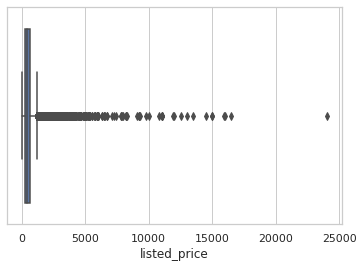

In [46]:
sns.set(style="whitegrid")
sns.boxplot(x=data['listed_price'])

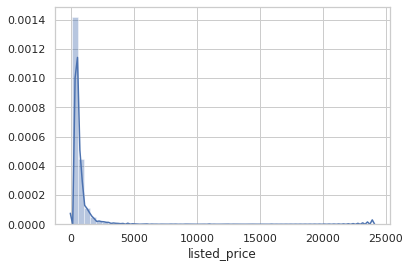

In [47]:
# 看起来挂牌价的分布非常不均衡
# 来看看它的分布
sns.distplot(data['listed_price'])

In [48]:
# 看一下偏度和锐度
print('偏度：', data['listed_price'].skew())
print('锐度: ', data['listed_price'].kurt())

偏度： 8.982863681077763
锐度:  143.44601280334524


In [49]:
# 二者皆相当高，说明
# 1. 挂牌价分布非常集中
# 2. 有少数房子挂牌价非常高


In [50]:
# 来看看价格大于5000万的房子
data.loc[data['listed_price']>5000, :].head()

,district,town_name,description,listed_price,layout,total_area,direction,decoration_rate,stairs,built_year,building_type,rooms,living_rooms,floor_height,total_floors,m5w1,near_facilities
261,xuhui,jianguoxilu,太原路永嘉路整栋别墅+带地下室带花园带露台+诚意出售,8180.0,6室3厅,481.36,南,简装,6层,1995.0,板楼 | 独栋别墅,6,3,NaN,6,不满五,False
339,pudong,biyun,二期英式都铎风格独栋别墅，临河，精装修，诚意出售,7100.0,7室3厅,370.33,南,精装,2层,2005.0,板楼 | 独栋别墅,7,3,NaN,2,不满五,False
570,pudong,huamu,D1户型，北进门南花园，占地千平,9100.0,5室3厅,604.83,南 北,简装,2层,2006.0,板楼 | 独栋别墅,5,3,NaN,2,不满五,False
881,pudong,lujiazui,财富海景前排02户型 朝南 新装修 高区 270度观景阳台,5800.0,3室2厅,351.78,南,精装,高楼层(共38层),2006.0,板楼,3,2,高,38,不满五,False
933,pudong,lujiazui,世茂顶楼复式，带游泳池，带450平大露台,24000.0,5室4厅,1080.63,东 西,精装,高楼层(共60层),NaN,板楼,5,4,高,60,不满五,False


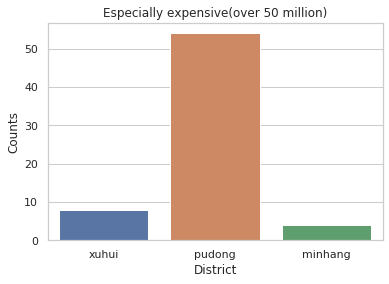

In [51]:
# 把价格高于5000万的称为特高价房
# 则特高价房的分布如下
esp_high = data.loc[data['listed_price']>5000, :].groupby('district').count()['town_name']
plt.figure(figsize=(6, 4))
ax = sns.barplot(esp_high.index, esp_high)


ax.set_title('Especially expensive(over 50 million)')
ax.set_xlabel('District')
ax.set_xticklabels(['xuhui', 'pudong', 'minhang'])
ax.set_ylabel('Counts')
plt.show()

In [52]:
# 特高价房只在三个区存在，徐汇， 浦东， 闵行
# 其中又有超过8成在浦东


In [53]:
# 把挂牌价在1000万至5000万的叫高价房
high = data[(data['listed_price']<=5000) & (data['listed_price']>1000)]\
.groupby('district').count()['town_name']
high

district
baoshan      15
minhang     352
pudong     1079
xuhui       247
Name: town_name, dtype: int64

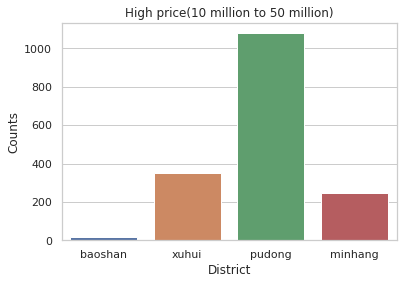

In [54]:
# 把挂牌价在1000万至5000万的叫高价房
high = data[(data['listed_price']<=5000) & (data['listed_price']>1000)]\
.groupby('district').count()['town_name']
plt.figure(figsize=(6, 4))
ax = sns.barplot(high.index, high)


ax.set_title('High price(10 million to 50 million)')
ax.set_xlabel('District')
ax.set_xticklabels(['baoshan', 'xuhui','pudong', 'minhang'])
ax.set_ylabel('Counts')
plt.show()

In [55]:
# 把挂牌价在200万到1000万叫正常价
normal = data[(data['listed_price']<=1000) & (data['listed_price']>200)]\
.groupby('district').count()['town_name']
normal

district
baoshan    1613
jiading     144
minhang    3701
pudong     6575
xuhui       961
Name: town_name, dtype: int64

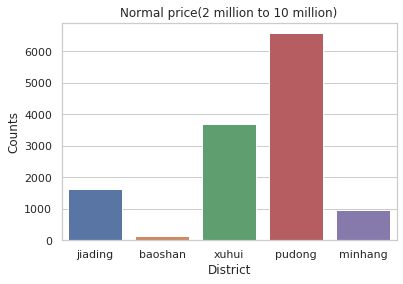

In [56]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(normal.index, normal)


ax.set_title('Normal price(2 million to 10 million)')
ax.set_xlabel('District')
ax.set_xticklabels(['jiading','baoshan', 'xuhui','pudong', 'minhang'])
ax.set_ylabel('Counts')
plt.show()

In [57]:
# 把价格在200万一下加低价
low = data[(data['listed_price']<=200)]\
.groupby('district').count()['town_name']
low

district
baoshan    368
jiading      5
minhang    348
pudong     663
xuhui       61
Name: town_name, dtype: int64

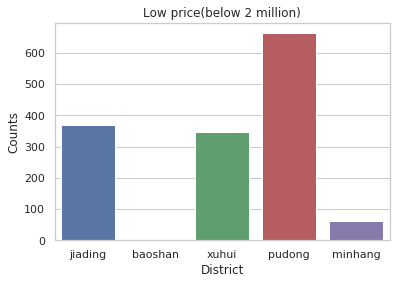

In [58]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(low.index, low)


ax.set_title('Low price(below 2 million)')
ax.set_xlabel('District')
ax.set_xticklabels(['jiading','baoshan', 'xuhui','pudong', 'minhang'])
ax.set_ylabel('Counts')
plt.show()

In [59]:
# 计算各区的平均价
mean_price = data.groupby('district')['listed_price'].mean()
mean_price

district
baoshan    364.337625
jiading    445.005369
minhang    556.851735
pudong     654.899642
xuhui      730.593401
Name: listed_price, dtype: float64

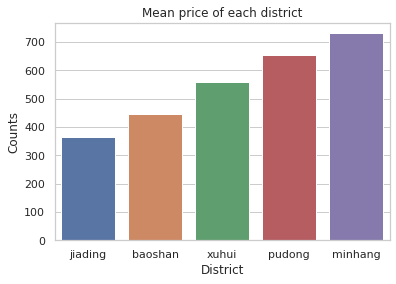

In [60]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(mean_price.index, mean_price)


ax.set_title('Mean price of each district')
ax.set_xlabel('District')
ax.set_xticklabels(['jiading','baoshan', 'xuhui','pudong', 'minhang'])
ax.set_ylabel('Counts')
plt.show()

In [61]:
# 可以看到各区之间的平均房价明显分成两个集团
# 由徐汇， 浦东， 闵行组成的高价区
# 和由嘉定， 宝山组成的较低价区

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


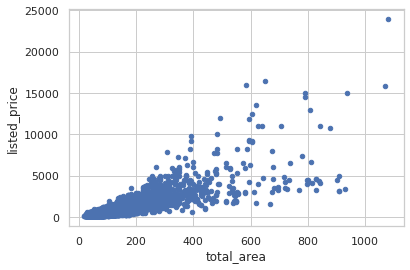

In [62]:
# 接下来我们来看挂牌价格与数字型特征之间的关系
# 显然total_area 与总价之间强烈相关
tmpdata = pd.concat([data['listed_price'], data['total_area']], axis=1)
tmpdata.plot.scatter(x='total_area', y='listed_price')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


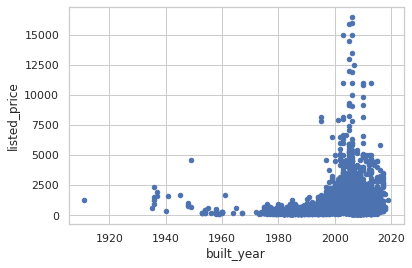

In [63]:
# 与建成年代的关系
tmpdata = pd.concat([data['listed_price'], data['built_year']], axis=1)
tmpdata.plot.scatter(x='built_year', y='listed_price')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


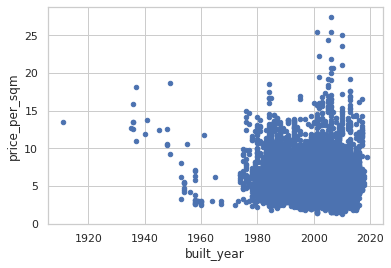

In [64]:
# 与建成年代之间显示了弱的正相关
# 我们来看看单位面积价格与建成年代之间的关系
tmpdata = pd.concat([data['listed_price']/data['total_area'], data['built_year']],
                    keys=['price_per_sqm', 'built_year'], axis=1)
tmpdata.plot.scatter(x='built_year', y='price_per_sqm')

In [65]:
# 这里可以看到通常较新的二手房的每平米单价较较旧的二手房每平米单价高
# 但对建成年代在1950年之前的房子其每平米单价则很高


In [66]:
# 来看一下这些古老的房子
old = data[data['built_year']<=1950]
old

,district,town_name,description,listed_price,layout,total_area,direction,decoration_rate,stairs,built_year,building_type,rooms,living_rooms,floor_height,total_floors,m5w1,near_facilities
154,xuhui,jianguoxilu,难得的老公寓，烫金地段，品质佳，保养好，还有商圈。,695.0,2室0厅,74.69,东,精装,低楼层(共10层),1949.0,板楼,2,0,低,10,不满五,False
184,xuhui,jianguoxilu,一家一世界一屋一风格，永嘉路上海旧时产权老式里弄,965.0,2室1厅,71.64,南,精装,低楼层(共1层),1936.0,板楼,2,1,低,1,不满五,False
386,xuhui,jianguoxilu,整栋新里，出行方便，全新装修！,1900.0,3室3厅,105.00,南,精装,低楼层(共3层),1937.0,板楼,3,3,低,3,不满五,False
2434,xuhui,hengshanlu,淮海路历史保护建筑，售后公房，看房方便！,1250.0,2室1厅,92.91,南,简装,低楼层(共7层),1911.0,板楼,2,1,低,7,不满五,False
3734,xuhui,hengshanlu,延庆路华亭路 售后公房 顶楼有阁楼,1280.0,3室1厅,101.82,南,简装,低楼层(共3层),1936.0,暂无数据,3,1,低,3,不满五,False
4837,xuhui,jianguoxilu,建国西路沿街整幢新里，历史风貌保护区，业主置换诚售,4600.0,4室3厅,245.70,南,简装,低楼层(共1层),1949.0,板塔结合,4,3,低,1,不满五,False
5727,xuhui,jianguoxilu,1楼带花园，向阳楼盘，孩子赢在起点线上 看房方便,600.0,1室1厅,47.00,南,精装,低楼层(共2层),1935.0,板楼,1,1,低,2,不满五,False
6576,xuhui,jianguoxilu,全上海在售适合自住新里总价醉低一套，卖掉再也第二套,1680.0,5室2厅,134.70,南 北,精装,低楼层(共3层),1945.0,板楼,5,2,低,3,不满五,False
7819,xuhui,hengshanlu,延庆路富民路，经典老公寓。外带30平阁楼不计算面积,1575.0,3室2厅,114.70,东 南 北,精装,高楼层(共4层),1941.0,板楼,3,2,高,4,不满五,False
8344,xuhui,hengshanlu,原汁原味的产权老公寓，三开间朝南，一梯一户，大阳台,1600.0,3室2厅,145.85,南 北,精装,中楼层(共5层),1937.0,板楼,3,2,中,5,不满五,False


In [67]:
# 全集中在徐汇区的建国西路和衡山路
# 此二路是当年的法租界，此处老房子或有文物属性


In [68]:
# 看下除掉这些老房子，徐汇区的平均房价
data[(data['district']=='徐汇') & (data['built_year']>1950)]['listed_price'].mean()

nan

In [69]:
# 可以看到徐汇区除掉这些老房子之后单价与浦东区差不多
# 我们继续来看建成年代对房价的影响


In [70]:
# 先用众数来填补建成年代
data['built_year'].mode()

0    1994.0
dtype: float64

In [71]:
data['built_year'].fillna(value=1994, inplace=True)

In [72]:
built_year = pd.to_datetime(data['built_year'].astype('int64').astype('str')+'0101', format='%Y%m%d')

In [73]:
data['built_year'] = built_year

In [74]:
print('min year: ', data['built_year'].min())
print('max year: ', data['built_year'].max())

min year:  1911-01-01 00:00:00
max year:  2019-01-01 00:00:00


In [75]:
# 看一下各区的平均值
tmpdf = data.groupby(['district', 'built_year']).sum()

In [76]:
tmpdf['price_per_sqm'] = tmpdf['listed_price'] / tmpdf['total_area']


In [77]:
tmpdf.reset_index(level='district', inplace=True)

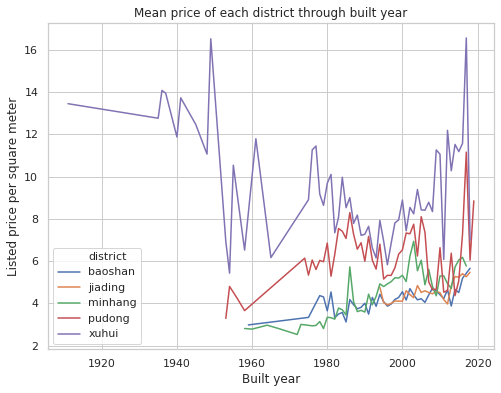

In [78]:
plt.figure(figsize=(8, 6))
ax = sns.lineplot(x=tmpdf.index, y=tmpdf['price_per_sqm'], hue=tmpdf['district'])

ax.set_title('Mean price of each district through built year')
ax.set_xlabel('Built year')

ax.set_ylabel('Listed price per square meter')
plt.show()

In [79]:
# 线条太过尖锐，来求一下滑动平均，以10年为窗口
jd = tmpdf[tmpdf['district']=='嘉定'].sort_index()['price_per_sqm'].rolling('3650D').mean()
bs = tmpdf[tmpdf['district']=='宝山'].sort_index()['price_per_sqm'].rolling('3650D').mean()
xh = tmpdf[tmpdf['district']=='徐汇'].sort_index()['price_per_sqm'].rolling('3650D').mean()
pd = tmpdf[tmpdf['district']=='浦东'].sort_index()['price_per_sqm'].rolling('3650D').mean()
mh = tmpdf[tmpdf['district']=='闵行'].sort_index()['price_per_sqm'].rolling('3650D').mean()

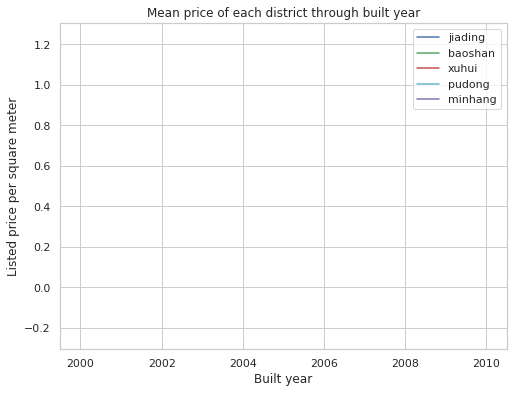

In [80]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Mean price of each district through built year')
ax.set_xlabel('Built year')

ax.set_ylabel('Listed price per square meter')
for i, d,c in zip([jd, bs, xh, pd, mh], ['jiading', 'baoshan', 'xuhui', 'pudong', 'minhang'], ['b','g','r','c','m']):
    ax.plot(i.index, i, c=c, label=d)
ax.legend()

In [81]:
# 现在我们可以清楚地看到大概在1950 年之前的建筑单价很高
# 而在1960年之后修的建筑单价随建成时间的推后而缓慢增长
# 可以构造一个表明是否为历史建筑的特征
data['historical'] = data['built_year'] < np.datetime64('1950-01-01')

In [82]:
# 接下来看挂牌价与类别型特征之间的联系


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]), <a list of 40 Text xticklabel objects>)

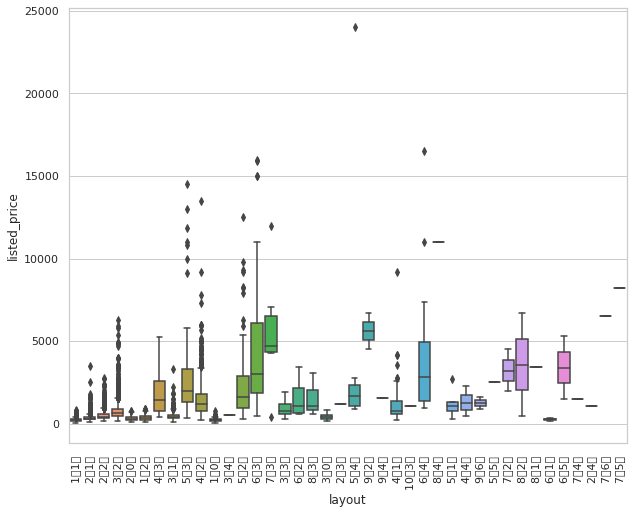

In [83]:
# 首先与房子户型
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(x='layout', y='listed_price', data=data)
plt.xticks(rotation=90)

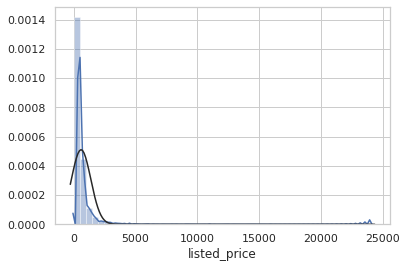

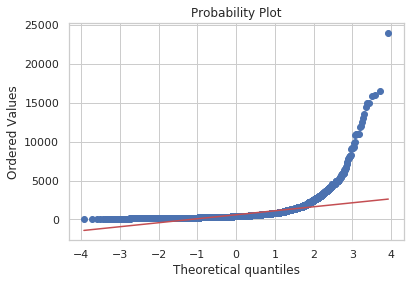

In [84]:
# 可以看到由于价格分布的巨大非正态性导致boxplot的主体部分被大大压缩
sns.distplot(data['listed_price'], fit=norm)
fig = plt.figure()
res = stats.probplot(data['listed_price'], plot=plt)

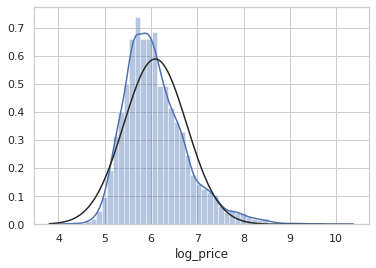

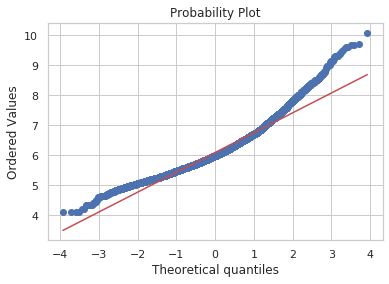

In [85]:
# 对listed_price 进行对数变换
data['log_price'] = np.log(data['listed_price'])
sns.distplot(data['log_price'], fit=norm)
fig = plt.figure()
res = stats.probplot(data['log_price'], plot=plt)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]), <a list of 40 Text xticklabel objects>)

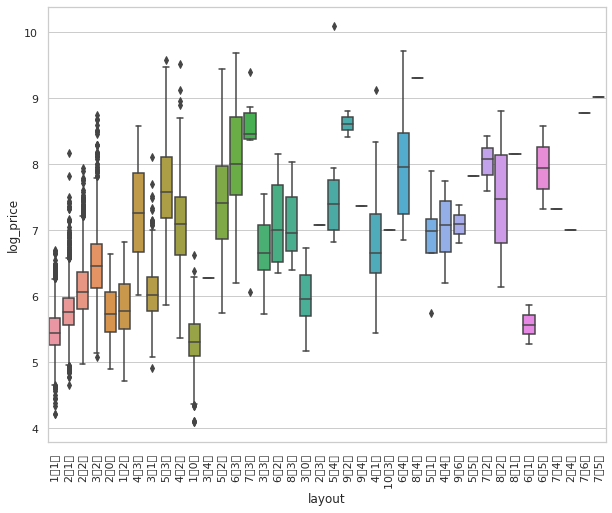

In [86]:
# 在看价格与房子户型的关系
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(x='layout', y='log_price', data=data)
plt.xticks(rotation=90)

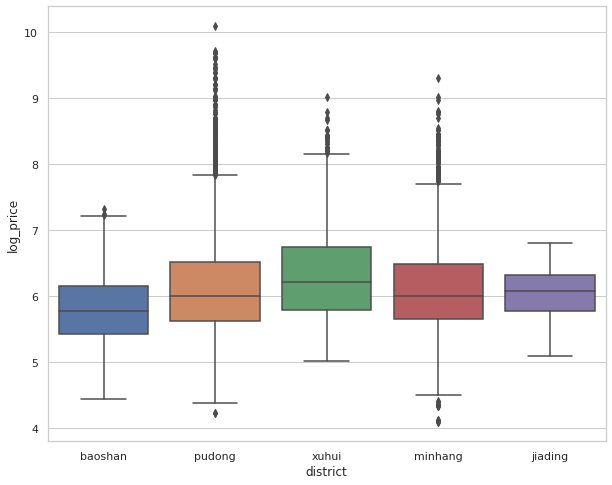

In [87]:
# 显而易见户型越大价格越高， 这是常识
# 看看区
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(x='district', y='log_price', data=data)

In [88]:
# 对每个区而言价格分布都相当集中但也相当右偏
# 特别对徐汇区而言， 其中的一些1950年之前修的房子
# 价格非常高

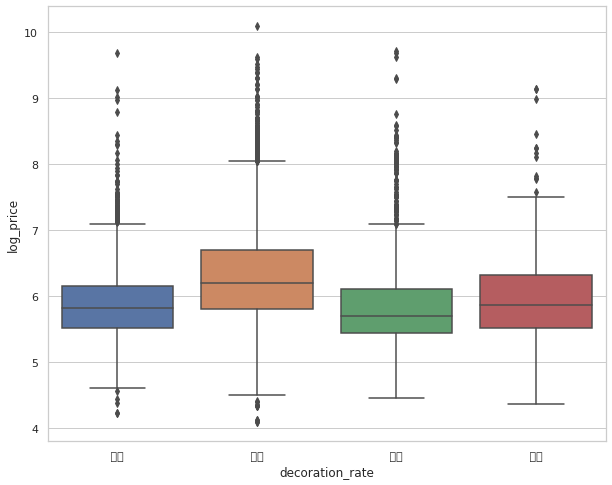

In [89]:
# 镇名太多，描述应我们之前已经从它中构造了足够信息，而朝向因之前已看到超过97%都朝南，所以这三者先不管
# 来看看装修等级
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(x='decoration_rate', y='log_price', data=data)

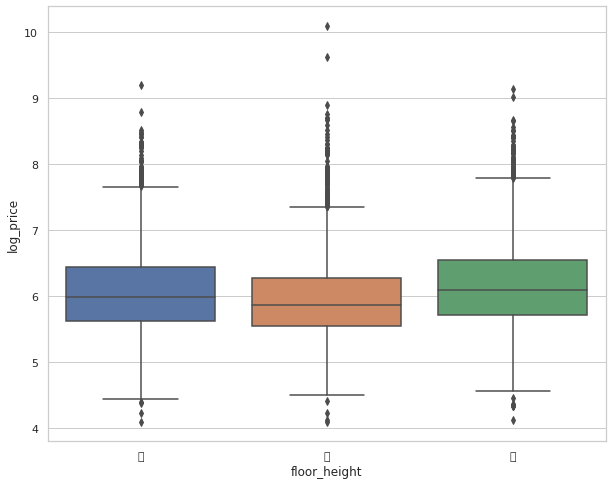

In [90]:
# 可以看到装修等级确实对房子挂牌价有比较大的影响
# 看看楼层高度
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(x='floor_height', y='log_price', data=data)

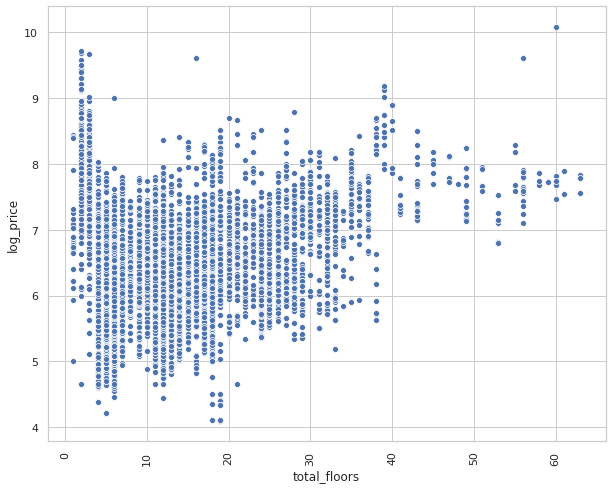

In [91]:
# 楼层高度的影响轻微
# 看看总楼高
data['total_floors'] = data['total_floors'].astype('int64')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.scatterplot(x='total_floors', y='log_price', data=data)
_ = plt.xticks(rotation=90)

In [92]:
# 可以看到总楼高不超过3的房子价格高，可能是因为很多是别墅
# 总楼高在4-20之间的房子价格最低，可能是比较老的低楼高房子
# 总楼高在20-40的房子价格升高了一点， 应该是比较现代的小区
# 而总楼高在40层以上的房子价格最高，应是位置很好的豪华住宅
# 为此我们把楼高分成四个等级
def floors_binned(x):
    """Turns total floors into four classes"""
    if x<=3:return 'very low'
    if x<=20: return 'low'
    if x<=40: return 'high'
    if x>40: return 'very high'
    
data['binned_total_floors'] = data['total_floors'].apply(floors_binned)

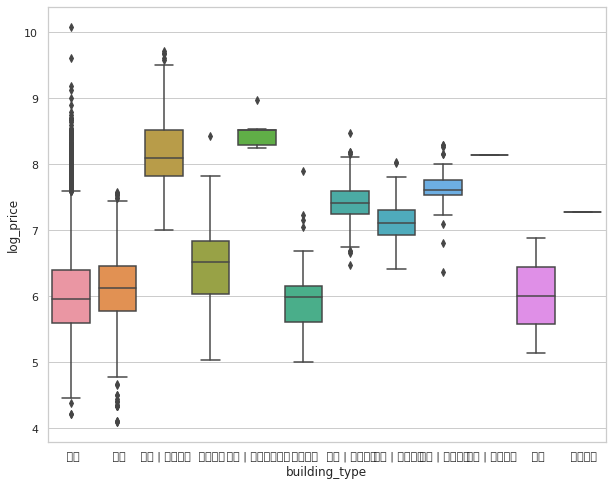

In [93]:
# 看一下楼型的影响
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(x='building_type', y='log_price', data=data)

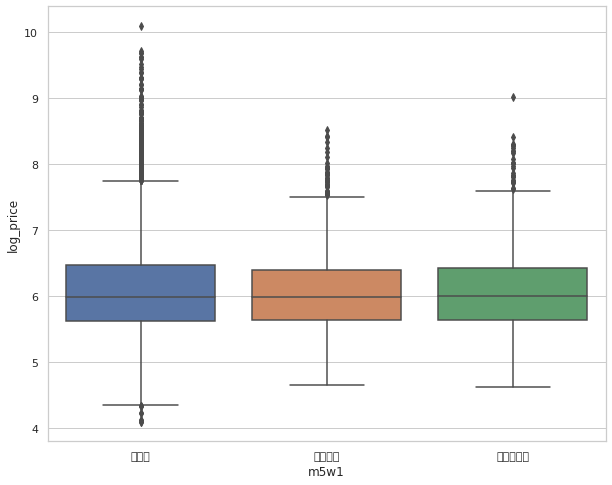

In [94]:
# 楼型对价格的影响也是很大的，因此这是个重要特征
# 来看满五唯一的影响
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(x='m5w1', y='log_price', data=data)

In [95]:
# 可以看到满五唯一与否对价格的中位数和分布区间几乎毫无影响
# 看起来这不是个重要的特征


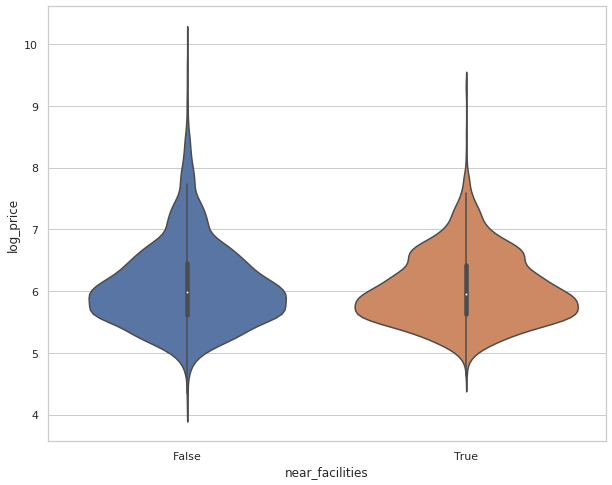

In [96]:
# 来看看靠近公共设施和是否历史建筑这两个binary特征的影响
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.violinplot(x='near_facilities', y='log_price', data=data)

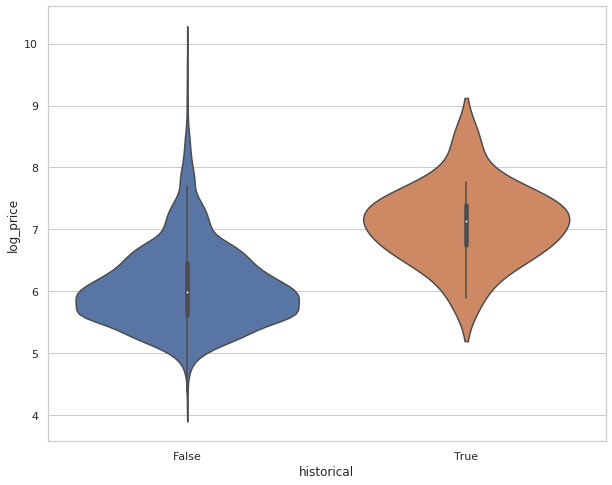

In [97]:
# 似无影响，说明房产经纪人在推荐话语里的这个描述对顾客的出价没什么影响
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.violinplot(x='historical', y='log_price', data=data)

In [98]:
# 历史建筑果然比非历史建筑的价格要高很多
# 而且其价格分布更集中，不过更可能是应为历史建筑的样本少所以显得集中

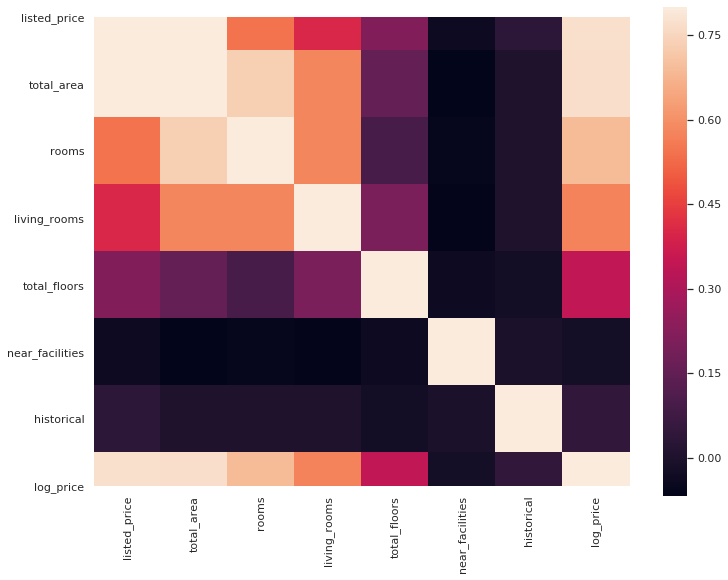

In [99]:
# 来看看各变量之间的相关性
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [100]:
# 或许厅室比对价格也有影响
# 让我们来造这样一个特征
data['living_room_ratio'] = data['living_rooms'] / data['rooms']

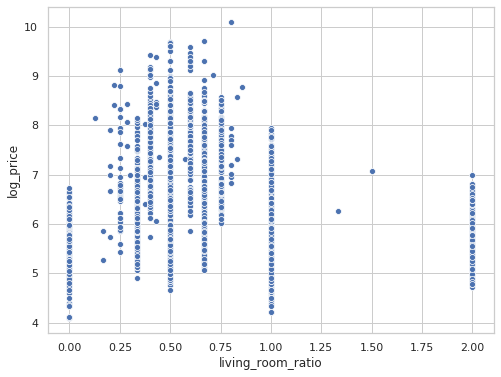

In [101]:
# 看看这个新造的特征
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.scatterplot(x='living_room_ratio', y='log_price', data=data)

In [102]:
# 果然如此， 无厅和厅室比超过1都会导致房子价格下降

In [103]:
# 检查一下missing data
data.isnull().sum()

district                 0
town_name                0
description              0
listed_price             0
layout                   0
total_area               0
direction                0
decoration_rate          0
stairs                   0
built_year               0
building_type            0
rooms                    0
living_rooms             0
floor_height           648
total_floors             0
m5w1                     0
near_facilities          0
historical               0
log_price                0
binned_total_floors      0
living_room_ratio        0
dtype: int64

In [104]:
# 只有楼层高度有缺失，因它不重要，我们用众数补全
fh = data['floor_height'].mode()
fh

0    高
dtype: object

In [105]:
data['floor_height'].fillna(value='高', inplace=True)

In [106]:
data.isnull().sum()

district               0
town_name              0
description            0
listed_price           0
layout                 0
total_area             0
direction              0
decoration_rate        0
stairs                 0
built_year             0
building_type          0
rooms                  0
living_rooms           0
floor_height           0
total_floors           0
m5w1                   0
near_facilities        0
historical             0
log_price              0
binned_total_floors    0
living_room_ratio      0
dtype: int64

In [107]:
# 将处理好的数据储存
data.to_csv(base_path+'preprocessed_data/preprocessed1.csv', index=False)